In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import os
import re
import json
plt.rcParams['figure.figsize'] = [5, 5]  # default hor./vert. size of plots, in inches

In [2]:
# function that gets all notebooks with a given config

def get_df(bitlen, seclvl, mtalg, client_ip, server_ip, min_bandwidth, max_bandwidth, ignore_bandwidth = False):
    names = []
    dicts = process_files_in_directory('../log/', 0, 26, 50)
    for k in dicts:
        # print(f"DEBUG: extracting config from {k}")
        s = ''.join(dicts[k])[50:]
        d = json.loads(s)
        # skip logs before different bit lengths were introduced
        if 'bit_length' not in d['misc']:
            continue
        if d['client']['ip_address'] == client_ip and d['server']['ip_address'] == server_ip:
            if d['misc']['security_level'] == seclvl and d['misc']['mt_algorithm'] == mtalg and d['misc']['bit_length'] == bitlen:
                #print(f"Found file that has appropriate config: {k}")
                bandwidth = extract_bandwidth_from_log_file(f'../log/{k}')
                if ignore_bandwidth:
                    names.append(k[6:-4])
                elif bandwidth:
                    if float(bandwidth) > min_bandwidth and float(bandwidth) < max_bandwidth:
                        names.append(k[6:-4])
    files_to_remove = []
    for file_name in names:
        if not os.path.exists(f'../dfs/{file_name}.csv'):
            # File doesn't exist, add it to the list for removal
            #print(f"df for {file_name} does not exist!")
            files_to_remove.append(file_name)
    
    # Remove the files that don't exist from the original list
    for file_name in files_to_remove:
        names.remove(file_name)
    return pd.concat((pd.read_csv(f"../dfs/{df_name}.csv") for df_name in names), ignore_index=True).reset_index(drop=True)

def read_lines(file_path, start_line, end_line):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        lines = lines[start_line:end_line]
    return lines
def read_until_info(file_path):
    out = []
    with open(file_path, 'r') as file:
        x = file.readline()
        while not 'INFO'in x:
            out.append(x)
            x = file.readline()
    return out
def process_files_in_directory(directory_path, n, m, k):
    result_dict = {}

    # Iterate over files in the directory
    for filename in os.listdir(directory_path):
        file_path = os.path.join(directory_path, filename)

        # Check if it's a file (not a directory)
        if os.path.isfile(file_path):
            # Check if the file has more than N rows
            with open(file_path, 'r') as file:
                line_count = sum(1 for _ in file)

            if line_count > k:
                # Read lines n to m from the file
                lines = read_until_info(file_path)

                # Store the lines in a JSON dictionary
                result_dict[filename] = lines

    return result_dict
def remove_chars_after_last_bracket(input_string):
    last_bracket_index = input_string.rfind('}')
    
    if last_bracket_index != -1:
        return input_string[:last_bracket_index + 1]
    else:
        # If there are no closing curly brackets, return the original string
        return input_string
    
def extract_bandwidth_from_log_file(log_file_path):

    # Open the log file and iterate through its lines
    with open(log_file_path, 'r') as log_file:
        for line in log_file:
            # Use a regular expression to match the "Bandwidth:" string and the float value
            match = re.search(r"andwidth: (\d+\.\d+) Mbits/sec", line)
            if match:
                bandwidth_str = match.group(1)
                return(float(bandwidth_str))

    return None

def remove_results_between(df, column, a, b):
    return df[(df[column].notna()) & (df[column] > a) & (df[column] < b)] 

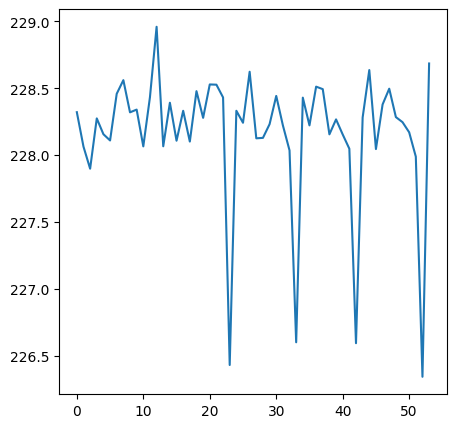

<Axes: >

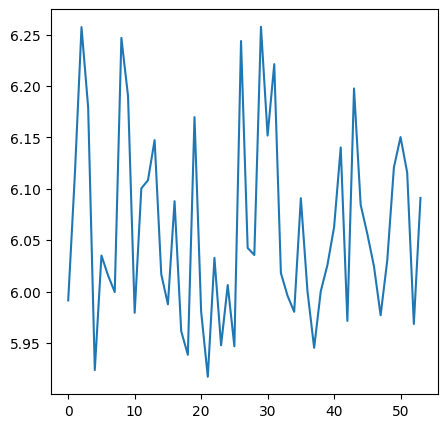

In [3]:
# exploring
df = get_df('64', '128', '2', '192.168.5.121','192.168.5.122', 0, 1000, True)
#df = remove_results_between(df, 'server.hardware.throughput', 60/8, 100/8)
(df['server.hardware.throughput']*8).plot()
plt.show()
(df['server.timings.total'] / 1000).plot()

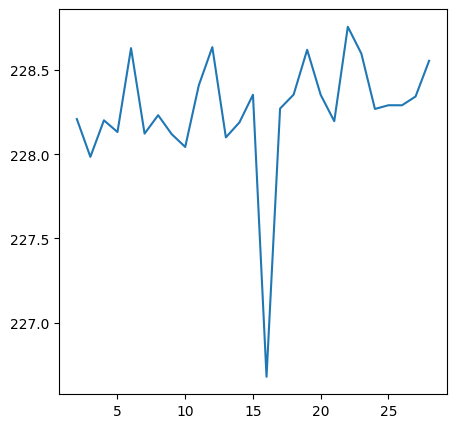

<Axes: >

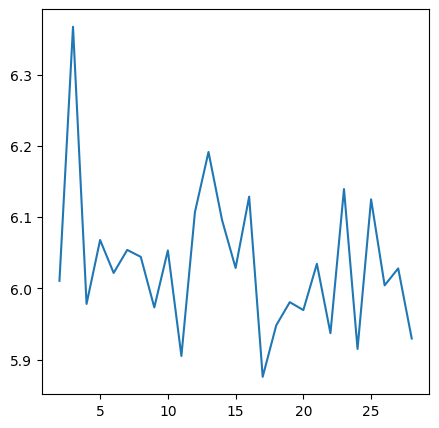

In [4]:
#lap 0

df_lap0 = get_df('64', '128', '0', '192.168.5.121','192.168.5.122', 0, 1000, True)
#df_lap0 = remove_results_between(df_lap0, 'server.hardware.throughput', 210/8, 250/8).tail(1000)
df_lap0 = df_lap0.dropna(subset=['server.timings.total'])
(df_lap0['server.hardware.throughput']*8).plot()
plt.show()
(df_lap0['server.timings.total'] / 1000).plot()

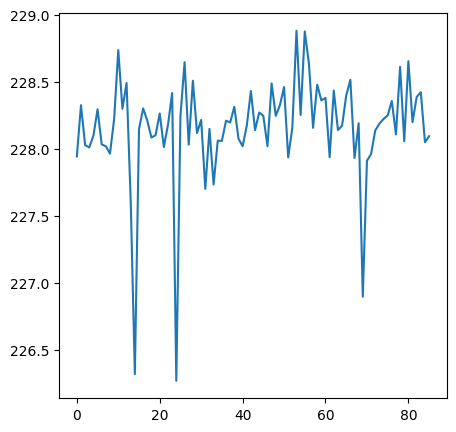

<Axes: >

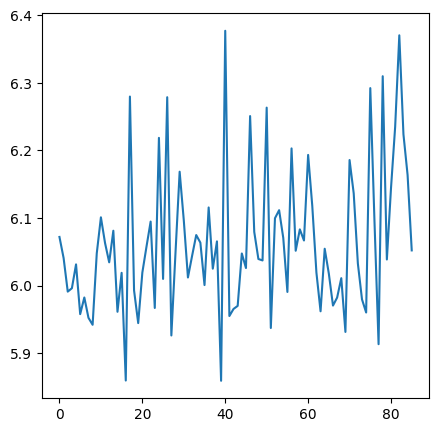

In [5]:
#lap 1

df_lap1 = get_df('64', '128', '1', '192.168.5.121','192.168.5.122', 0, 1000, True)
#df = remove_results_between(df, 'server.hardware.throughput', 60/8, 100/8)
(df_lap1['server.hardware.throughput']*8).plot()
plt.show()
(df_lap1['server.timings.total'] / 1000).plot()

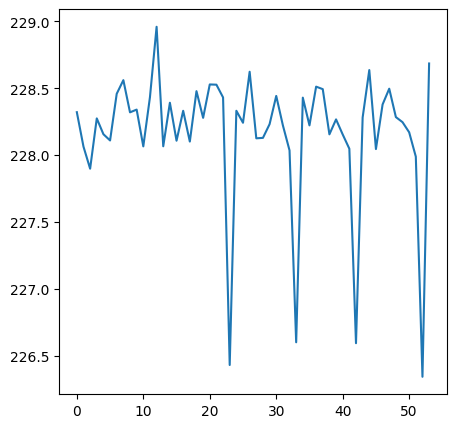

<Axes: >

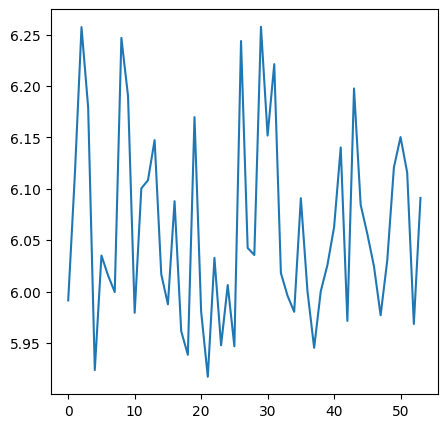

In [6]:
#lap 2

df_lap2 = get_df('64', '128', '2', '192.168.5.121','192.168.5.122', 0, 1000, True)
#df_lap2 = remove_results_between(df_lap2, 'server.hardware.throughput', 200/8, 300/8)
(df_lap2['server.hardware.throughput']*8).plot()
plt.show()
(df_lap2['server.timings.total'] / 1000).plot()

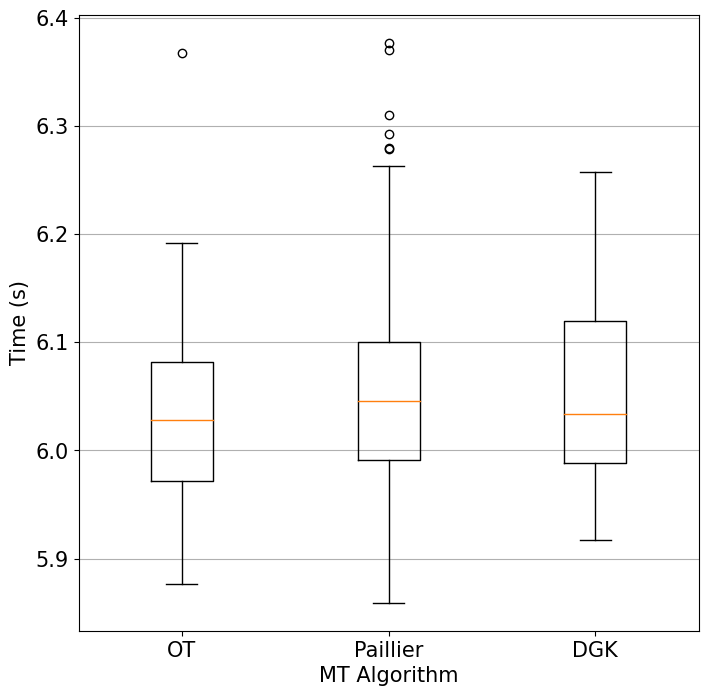

In [7]:
# plotting
plt.rcParams.update({'font.size': 15})
df_list = [df_lap0.head(1000), df_lap1.head(1000), df_lap2.head(1000)]
plt.rcParams['figure.figsize'] = [8, 8]  # default hor./vert. size of plots, in inches
# labels = [''] * len(df_list)
# for i in range(len(df_list)):
#     labels[i] += f"{df_list[i]['server.hardware.throughput'].mean() * 8:.0f}"
labels = ['OT', 'Paillier', 'DGK']
ax = plt.boxplot([df['server.timings.total'] /1000 for df in df_list], labels=labels)
plt.xlabel("MT Algorithm")
plt.ylabel("Time (s)")
plt.grid(axis='y')
plt.savefig("ex3_time.pdf", format="pdf", bbox_inches="tight")

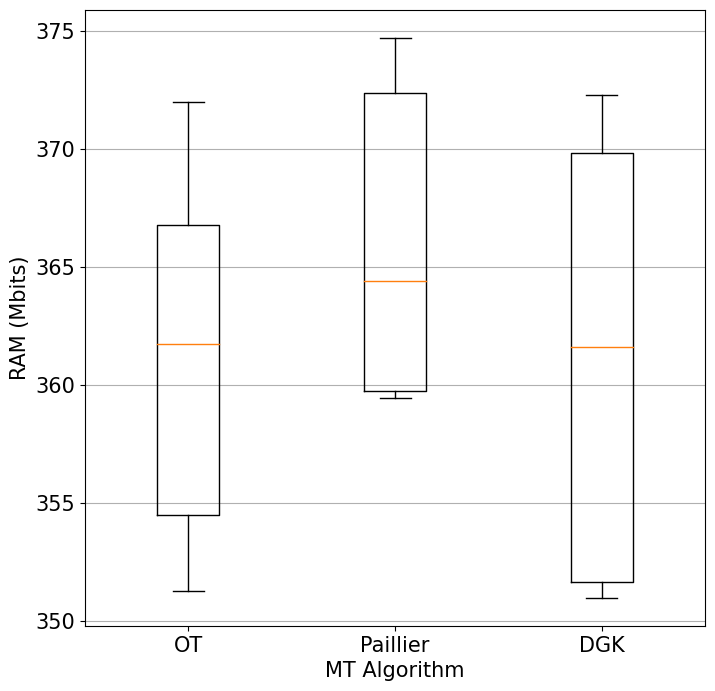

In [8]:
# plotting
plt.rcParams.update({'font.size': 15})
df_list = [df_lap0.head(1000), df_lap1.head(1000), df_lap2.head(1000)]
plt.rcParams['figure.figsize'] = [8, 8]  # default hor./vert. size of plots, in inches
# labels = [''] * len(df_list)
# for i in range(len(df_list)):
#     labels[i] += f"{df_list[i]['server.hardware.throughput'].mean() * 8:.0f}"
labels = ['OT', 'Paillier', 'DGK']
ax = plt.boxplot([df['server.Maximum resident set size (kbytes)'] /1000 for df in df_list], labels=labels)
plt.xlabel("MT Algorithm")
plt.ylabel("RAM (Mbits)")
plt.grid(axis='y')
plt.savefig("ex3_ram.pdf", format="pdf", bbox_inches="tight")

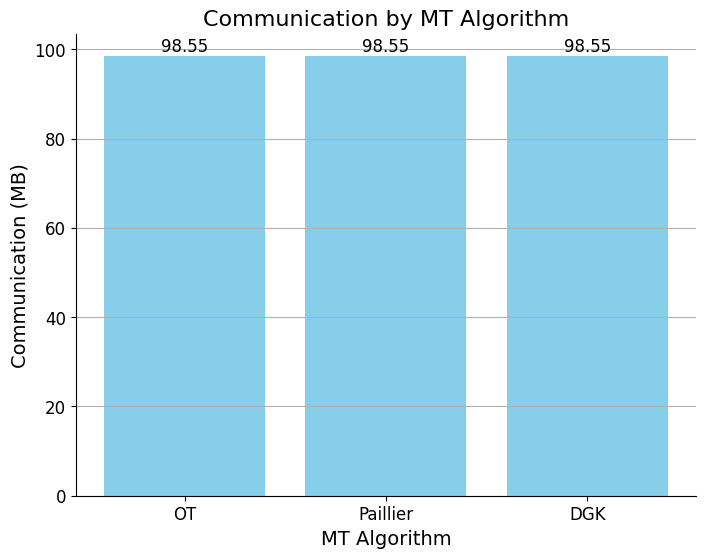

In [12]:
import matplotlib.pyplot as plt

# Assuming df_list contains your DataFrames df_lap0, df_lap1, df_lap2
plt.rcParams.update({'font.size': 12})  # Set font size
df_list = [df_lap0.head(1000), df_lap1.head(1000), df_lap2.head(1000)]
# Define data
data = [df['server.communication.total.sent'].mean() / 1000000 for df in df_list]

# Define labels
labels = ['OT', 'Paillier', 'DGK']

# Create bar plot
fig, ax = plt.subplots(figsize=(8, 6))  # Set figure size
bars = ax.bar(labels, data, color='skyblue')  # Set color

# Add data labels
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval, 2), ha='center', va='bottom')

# Set labels and title
plt.xlabel("MT Algorithm", fontsize=14)  # Set x-axis label and font size
plt.ylabel("Communication (MB)", fontsize=14)  # Set y-axis label and font size
plt.title("Communication by MT Algorithm", fontsize=16)  # Set title and font size

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add gridlines
plt.grid(axis='y')

# Save plot
plt.savefig("ex3_comm.pdf", format="pdf", bbox_inches="tight")

# Show plot
plt.show()


In [10]:
for d in df_list:
    print(f"Bandwidth: {d['server.hardware.throughput'].mean()}")
    print (f"Time: {d['server.timings.total'].mean() / 1000}")
    print (f"RAM: {d['server.Maximum resident set size (kbytes)'].mean() / 100}")
    print (f"RAM: {d['server.communication.total.sent'].mean() / 100}")
    

Bandwidth: 28.532195060470368
Time: 6.0339790740740735
RAM: 3608.859259259259
RAM: 985464.78
Bandwidth: 28.520329986683727
Time: 6.064119965116279
RAM: 3660.292558139535
RAM: 985464.96
Bandwidth: 28.521040728818516
Time: 6.060847370370372
RAM: 3607.4022222222225
RAM: 985464.96
